In [100]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas as pd

from fdiff.dataloaders.datamodules import ECGDatamodule,NASDAQDatamodule, NASADatamodule, MIMICIIIDatamodule, USDroughtsDatamodule, Datamodule
from fdiff.utils.fourier import spectral_density
from pathlib import Path

In [93]:
data_path = Path.cwd() / "../data/"

datasets: dict[str, Datamodule] = {
    "Electrocardiograms": ECGDatamodule(data_dir=data_path),
    "MIMIC-III": MIMICIIIDatamodule(data_dir=data_path, n_feats=40),
    "NASDAQ-2019": NASDAQDatamodule(data_dir=data_path),
    "NASA-Charge": NASADatamodule(data_dir=data_path),
    "NASA-Discharge": NASADatamodule(data_dir=data_path, subdataset="discharge"),
    "US-Droughts": USDroughtsDatamodule(data_dir=data_path)
}

In [108]:
spectral_data: list[dict] = []
temporal_data: list[dict] = []

for dataset_name, datamodule in datasets.items():
    
    # Prepare data
    datamodule.prepare_data()
    datamodule.setup()
    
    # Extract training features
    X_train = datamodule.X_train
    
    # Compute specral representation
    X_spec = spectral_density(X_train)
    
    
    # Compute mean and standard error of the normalized spectral density
    X_spec_norm_mean = torch.mean((X_spec.sum(dim=2, keepdim=True) / X_spec.sum(dim=(1, 2), keepdim=True)), dim=(0,2))
    X_spec_norm_se = torch.std((X_spec.sum(dim=2, keepdim=True) / X_spec.sum(dim=(1, 2), keepdim=True)), dim=(0,2)) / math.sqrt(len(X_spec))
    
    # Compute normalized frequency
    freq_norm = [k / X_spec.shape[1] for k in range(1, 1+X_spec.shape[1])]
    
    
    # Record the spectral data
    spectral_data.extend(
        [
            {
        "Dataset": dataset_name,
        "Normalized Frequency": freq_norm[k],
        "Normalized Spectral Density": X_spec_norm_mean[k].item(),
        "SE": X_spec_norm_se[k].item()
            } for k in range(len(freq_norm))
        ] 
        )
    
    # Compute the mean and standard error of the normalized energy
    X_energy_mean = torch.mean((X_train**2).sum(dim=2, keepdim=True) / (X_train**2).sum(dim=(1, 2), keepdim=True), dim=(0, 2))
    X_energy_std = torch.std((X_train**2).sum(dim=2, keepdim=True) / (X_train**2).sum(dim=(1, 2), keepdim=True), dim=(0, 2))
    
    # Compute the normalized time
    time_norm = [k / X_train.shape[1] for k in range(1, 1+X_train.shape[1])]
    
    # Record the temporal data
    temporal_data.extend(
        [
            {
        "Dataset": dataset_name,
        "Normalized Time": time_norm[k],
        "Normalized Energy": X_energy_mean[k].item(),
        "SE": X_energy_std[k].item()
            } for k in range(len(time_norm))
        ] 
        )
    
spectral_df = pd.DataFrame(spectral_data)   
temporal_df = pd.DataFrame(temporal_data)
    

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

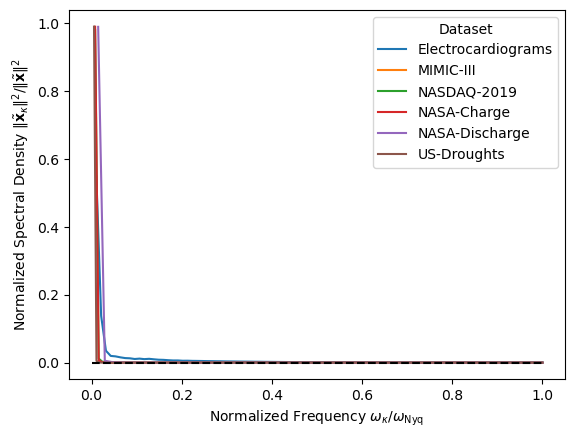

In [116]:
sns.lineplot(data=spectral_df,x="Normalized Frequency", y="Normalized Spectral Density", hue="Dataset")
plt.ylabel(r"Normalized Spectral Density $\|\tilde{\mathbf{x}}_\kappa\|^2  /  \| \tilde{\mathbf{x}} \|^2$")
plt.hlines(0, 0, 1, colors="black", linestyles="dashed")
plt.xlabel(r"Normalized Frequency $\omega_\kappa  /  \omega_{\mathrm{Nyq}}$")
plt.show()

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

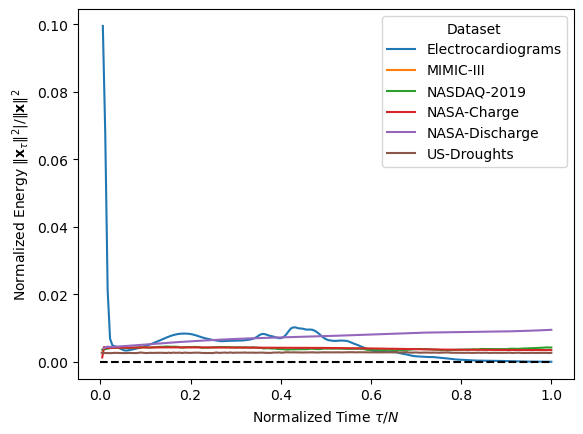

In [115]:
sns.lineplot(data=temporal_df, x="Normalized Time", y="Normalized Energy", hue="Dataset") 
plt.ylabel(r"Normalized Energy $\|\mathbf{x}_\tau \|^2| / \| \mathbf{x} \|^2$")
plt.xlabel(r"Normalized Time $\tau / N$")
plt.hlines(0, 0, 1, colors="black", linestyles="dashed")
plt.show()